# Reinforce


In this notebook we will train OpenAI Gym's CartPole environmnet with REINFORCE Algorithm

### 1. Import Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define Architecture of the Policy

In [2]:
env = gym.make('CartPole-v0')
print('Observation space : ', env.observation_space)
print('Action space : ', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Observation space :  Box(4,)
Action space :  Discrete(2)


In [3]:
gym.logger.set_level(40)
# Random seed
torch.manual_seed(0)
env.seed(0)


[0]

In [4]:
class Policy(nn.Module):
    def __init__(self, state_size = 4, hidden_size = 16, action_size = 2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [5]:
# Practice
state = env.reset()
print(state)

[-0.04456399  0.04653909  0.01326909 -0.02099827]


In [6]:
# Practice
state = torch.from_numpy(state).float().unsqueeze(0).to(device)
print(state)

tensor(1.00000e-02 *
       [[-4.4564,  4.6539,  1.3269, -2.0998]], device='cuda:0')


In [7]:
# Practice
policy = Policy().to(device)
probs = policy.forward(state).cpu()
print(probs)

tensor([[ 0.4105,  0.5895]])


In [8]:
# Practice
m = Categorical(probs)
print(m)

Categorical()


In [9]:
# Practice
#a = np.array([0.6, 0.4])
#a = torch.from_numpy(a).float().unsqueeze(0).to(device)
a = torch.tensor([0.99, 0.01])
print(a)

b = Categorical(a)
action = b.sample()

print("action : ", action)
print("action.item() : ", action.item())
print("b.log_prob(action) : ", b.log_prob(action))

tensor([ 0.9900,  0.0100])
action :  tensor(0)
action.item() :  0
b.log_prob(action) :  tensor(1.00000e-02 *
       -1.0050)


## 3. Train the Agent with REINFORCE

In [25]:
# Practice
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

num_episodes= 1000
max_t = 100
gamma = 1.0
print_every = 100

scores_deque = deque(maxlen=100)
scores = []
for i_episode in range(1, num_episodes+1):
    saved_log_probs = []
    rewards = []
    state = env.reset()
    for t in range(max_t):
        action, log_prob = policy.act(state)
        saved_log_probs.append(log_prob)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
    scores_deque.append(sum(rewards))
    scores.append(sum(rewards))



    discounts = [ gamma**i for i in range(len(rewards)+1)]
    R = sum( [ a*b for a,b in zip(discounts, rewards) ] )

    #print("discounts :", discounts)
    #print("Rewards :", rewards)
    #print("saved_log_probs :", saved_log_probs)

    policy_loss = []
    for log_prob in saved_log_probs:
        policy_loss.append(-log_prob * R)
        #print(policy_loss)
    policy_loss = torch.cat(policy_loss).sum()
    #print("policy_loss : ", policy_loss)
    # torch.cat -> Concatenates the given sequence of seq tensor in the given dimension

    """
    
    if A and B are of shape (3, 4), torch.cat([A, B], dim=0) 
    will be of shape (6, 4) and torch.stack([A, B], dim=0) will be of shape (2, 3, 4).
    
    """
    
    optimizer.zero_grad() # Sets gradients of all model paramters to zero
    policy_loss.backward()
    optimizer.step()
    
    """
    print("scores : ", scores)
    print( "---------------")
    """
    if i_episode % print_every == 0:
        print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    if np.mean(scores_deque) >= 195.0:
        print("Environment solved in {:d} episodes!\tAverage Score: {:.2f}".format(i_episode-100, np.mean(scores)))
        break 
        
#print(scores)
    

Episode 100	Average Score: 20.56
Episode 200	Average Score: 21.08
Episode 300	Average Score: 49.97
Episode 400	Average Score: 64.72
Episode 500	Average Score: 89.37
Episode 600	Average Score: 76.94
Episode 700	Average Score: 97.01
Episode 800	Average Score: 83.49
Episode 900	Average Score: 44.83
Episode 1000	Average Score: 46.34


In [ ]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(num_episodes=2000, max_t = 1000, gamma = 1.0, print_every = 100):
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, num_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [ gamma**i for i in range(len(rewards)+1)]
        R = sum( [ a*b for a,b in zip(discounts, rewards) ] )
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
            #print("policy_loss : ", policy_loss)
        policy_loss = torch.cat(policy_loss).sum()
        print("policy_loss : ->", policy_loss)
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 198.0:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
                
                break
    return scores

scores = reinforce()

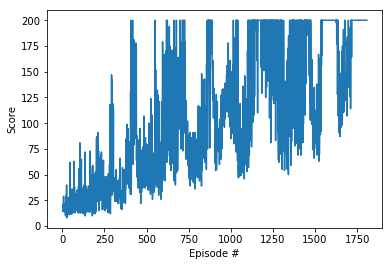

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [48]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()